In [38]:
"""*****************************************************************************
Purpose: To analyze the sentiments of the reddit
This program uses Vader SentimentIntensityAnalyzer to calculate the ticker compound value.
You can change multiple parameters to suit your needs. See below under "set program parameters."
Implementation:
I am using sets for 'x in s' comparison, sets time complexity for "x in s" is O(1) compare to list: O(n).
Limitations:
It depends mainly on the defined parameters for current implementation:
It completely ignores the heavily downvoted comments, and there can be a time when
the most mentioned ticker is heavily downvoted, but you can change that in upvotes variable.
Author: github:asad70
-------------------------------------------------------------------
****************************************************************************"""
import ssl

from nltk import download
from praw import Reddit
from data import us, blacklist, new_words
from time import time
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib
from squarify import plot
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from emoji import get_emoji_regexp
from re import sub as reg_sub  # removes links
from en_core_web_sm import load
from string import punctuation
from base64 import b64encode
from io import BytesIO
from stocker import predict
import tensorflow as tf

tf.get_logger().setLevel("ERROR")
matplotlib.rcParams['axes.edgecolor'] = '#fff'

In [39]:

"""############################################################################"""
# set the program parameters
subs = ["wallstreetbets"]  # sub-reddit to search
# posts flairs to search || None flair is automatically considered
post_flairs = {"Daily Discussion", "Weekend Discussion", "Discussion"}
# authors whom comments are allowed more than once
goodAuth = {"AutoModerator"}
uniqueCmt = True  # allow one comment per author per symbol
ignoreAuthP = {"example"}  # authors to ignore for posts
ignoreAuthC = {"example"}  # authors to ignore for comment
upvoteRatio = 0.7  # upvote ratio for post to be considered, 0.70 = 70%
ups = 20  # define # of upvotes, post is considered if upvotes exceed this #
limit = 1  # define the limit, comments 'replace more' limit
upvotes = 2  # define # of upvotes, comment is considered if upvotes exceed this #
picks = 20  # define # of picks here, prints as "Top ## picks are:"
picks_ayz = 10  # define # of picks for sentiment analysis
INDEX = ["Bearish", "Neutral", "Bullish", "Total/Compound"]
"""############################################################################"""

user_agent=""
client_id=""
client_secret=""
username=""
password=""

In [40]:

def data_extractor(reddit):
    """extracts all the data from reddit
    Parameter: reddt: reddit obj
    Return:    posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz

                posts: int: # of posts analyzed
                 c_analyzed: int: # of comments analyzed
                 tickers: dict: all the tickers found
                titles: list: list of the title of posts analyzed
                 a_comments: dict: all the comments to analyze
                 picks: int: top picks to analyze
                 subs: int: # of subreddits analyzed
                picks_ayz: int: top picks to analyze

    """

    posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
    cmt_auth = {}

    for sub in subs:
        subreddit = reddit.subreddit(sub)
        hot_python = subreddit.hot()  # sorting posts by hot
        # Extracting comments, symbols from subreddit
        for submission in hot_python:
            flair = submission.link_flair_text
            author = submission.author.name

            # checking: post upvote ratio # of upvotes, post flair, and author
            if (
                submission.upvote_ratio >= upvoteRatio
                and submission.ups > ups
                and (flair in post_flairs or flair is None)
                and author not in ignoreAuthP
            ):
                submission.comment_sort = "new"
                comments = submission.comments
                titles.append(submission.title)
                posts += 1
                try:
                    submission.comments.replace_more(limit=limit)
                    for comment in comments:
                        # try except for deleted account?
                        try:
                            auth = comment.author.name
                        except:
                            pass
                        c_analyzed += 1

                        # checking: comment upvotes and author
                        if comment.score > upvotes and auth not in ignoreAuthC:
                            split = comment.body.split(" ")
                            for word in split:
                                word = word.replace("$", "")
                                # upper = ticker, length of ticker <= 5, excluded words,
                                if (
                                    word.isupper()
                                    and len(word) <= 5
                                    and word not in blacklist
                                    and word in us
                                ):

                                    # unique comments, try/except for key errors
                                    if uniqueCmt and auth not in goodAuth:
                                        try:
                                            if auth in cmt_auth[word]:
                                                break
                                        except:
                                            pass

                                    # counting tickers
                                    if word in tickers:
                                        tickers[word] += 1
                                        a_comments[word].append(comment.body)
                                        cmt_auth[word].append(auth)

                                    else:
                                        tickers[word] = 1
                                        cmt_auth[word] = [auth]
                                        a_comments[word] = [comment.body]

                except Exception as e:
                    print(e)

    return posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz


def print_helper(tickers, picks, time, start_time):
    """prints out top tickers, and most mentioned tickers

    Parameter:   tickers: dict: all the tickers found
                 picks: int: top picks to analyze
                 c_analyzed: int: # of comments analyzed
                 posts: int: # of posts analyzed
                 subs: int: # of subreddits analyzed
                titles: list: list of the title of posts analyzed
                 time: time obj: top picks to analyze
                start_time: time obj: prog start time

    Return: symbols: dict: dict of sorted tickers based on mentions
            times: list: include # of time top tickers is mentioned
            top: list: list of top tickers
    """

    # sorts the dictionary
    symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse=True))
    top_picks = list(symbols.keys())[0:picks]
    time = time() - start_time

    # print top picks
    # print(
    #     "It took {t:.2f} seconds to analyze {c} comments in {p} posts in {s} subreddits.\n".format(
    #         t=time, c=c_analyzed, p=posts, s=len(subs)
    #     )
    # )
    # print("Posts analyzed saved in titles")
    # for i in titles:
    #     print(i)  # prints the title of the posts analyzed

    # print(f"\n{picks} most mentioned tickers: ")

    times = []
    top = []
    for i in top_picks:
        # print(f"{i}: {symbols[i]}")
        times.append(symbols[i])
        top.append(f"{i}: {symbols[i]}")

    return symbols, times, top


def sentiment_analysis(picks_ayz, a_comments, symbols):
    """analyzes sentiment anaylsis of top tickers

    Parameter:   picks_ayz: int: top picks to analyze
                 a_comments: dict: all the comments to analyze
                 symbols: dict: dict of sorted tickers based on mentions
    Return:      scores: dictionary: dictionary of all the sentiment analysis

    """
    scores = {}

    vader = SentimentIntensityAnalyzer()
    vader.lexicon.update(new_words)  # adding custom words from data.py
    picks_sentiment = list(symbols.keys())[0:picks_ayz]

    for symbol in picks_sentiment:
        stock_comments = a_comments[symbol]
        for cmnt in stock_comments:

            emojiless = get_emoji_regexp().sub("", cmnt)  # remove emojis

            # remove punctuation
            text_punc = "".join([char for char in emojiless if char not in punctuation])
            text_punc = reg_sub("[0-9]+", "", text_punc)

            # tokenizeing and cleaning
            tokenizer = RegexpTokenizer("\w+|\$[\d\.]+|http\S+")
            tokenized_string = tokenizer.tokenize(text_punc)
            # convert to lower case
            lower_tokenized = [word.lower() for word in tokenized_string]

            # remove stop words
            nlp = load()
            stopwords = nlp.Defaults.stop_words
            sw_removed = [word for word in lower_tokenized if word not in stopwords]

            # normalize the words using lematization
            lemmatizer = WordNetLemmatizer()
            lemmatized_tokens = [lemmatizer.lemmatize(w) for w in sw_removed]

            # calculating sentiment of every word in comments n combining them
            score_cmnt = {"neg": 0.0, "neu": 0.0, "pos": 0.0, "compound": 0.0}

            word_count = 0
            for word in lemmatized_tokens:
                if word.upper() not in us:
                    score = vader.polarity_scores(word)
                    word_count += 1
                    for key, _ in score.items():
                        score_cmnt[key] += score[key]
                else:
                    score_cmnt["pos"] = 2.0

            # calculating avg.
            try:  # handles: ZeroDivisionError: float division by zero
                for key in score_cmnt:
                    score_cmnt[key] = score_cmnt[key] / word_count
            except:
                pass

            # adding score the the specific symbol
            if symbol in scores:
                for key, _ in score_cmnt.items():
                    scores[symbol][key] += score_cmnt[key]
            else:
                scores[symbol] = score_cmnt

        # calculating avg.
        for key in score_cmnt:
            scores[symbol][key] = scores[symbol][key] / symbols[symbol]
            scores[symbol][key] = "{pol:.3f}".format(pol=scores[symbol][key])

    return scores


def visualization(picks_ayz, scores, picks, times, top):
    """prints sentiment analysis
       makes a most mentioned picks chart
       makes a chart of sentiment analysis of top picks

    Parameter:   picks_ayz: int: top picks to analyze
                 scores: dictionary: dictionary of all the sentiment analysis
                 picks: int: most mentioned picks
                times: list: include # of time top tickers is mentioned
                top: list: list of top tickers
    Return:       None
    """

    # printing sentiment analysis
    # print(f"\nSentiment analysis of top {picks_ayz} picks:")
    df = DataFrame(scores)
    df.index = INDEX
    df = df.T
    # print(df)

    # Date Visualization
    # most mentioned picks
    plot(sizes=times, label=top, alpha=0.7)
    # plt.axis("off")
    [i.set_color("white") for i in plt.gca().get_xticklabels()]
    [i.set_color("white") for i in plt.gca().get_yticklabels()]
    plt.title(f"{picks} most mentioned picks")
    # figure_mentioned = BytesIO()
    # plt.savefig(figure_mentioned, format="png")
    # Sentiment analysis
    df = df.astype(float)

    df.plot(
        kind="bar",
        colormap="Paired",
        stacked=True,
        title=f"Sentiment analysis of top {picks_ayz} picks:",
    )
    [i.set_color("white") for i in plt.gca().get_xticklabels()]
    [i.set_color("white") for i in plt.gca().get_yticklabels()]
    # figure_sentiment = BytesIO()
    # plt.savefig(figure_sentiment, format="png")
    plt.show
    return df


def main():
    """main function
    Parameter:   None
    Return:       None
    """
    start_time = time()

    # reddit client
    reddit = Reddit(
        user_agent=user_agent,
        client_id=client_id,
        client_secret=client_secret,
        username=username,
        password=password,
    )

    (
        posts,
        c_analyzed,
        tickers,
        titles,
        a_comments,
        picks,
        subs,
        picks_ayz,
    ) = data_extractor(reddit)
    symbols, times, top = print_helper(tickers, picks, time, start_time)
    scores = sentiment_analysis(picks_ayz, a_comments, symbols)
    df = visualization(
        picks_ayz, scores, picks, times, top
    )

    # encoded_mentioned = b64encode(figure_mentioned.getvalue())
    # encoded_sentiment = b64encode(figure_sentiment.getvalue())
    map_tickers = {}
    for ticker in list(tickers.keys()):
        try:
            map_tickers[ticker] = predict.tomorrow(ticker)
        except:
            print(f"Ticker {ticker} not found")
    df_tickers = DataFrame.from_dict(map_tickers, orient='index', columns=["Predicted Price [$]", "Error in [%]", "Next day"])
    print(df)
    print(df_tickers)
    # return {
    #     "statusCode": 200,
    #     "body": f"<html>\n<style>\ntable {{\nborder-collapse: collapse;\n\nmargin: 25px "
    #             f"88px;\nfont-size: "
    #     f"0.9em;\nfont-family: sans-serif;\nmin-width: 400px;\nbox-shadow: 0 0 20px rgba(0, 0, 0, "
    #     f"0.15);\n}}\n th,\n td{{\n padding: 12px 15px;\n}}\n tbody tr {{\n border-bottom: 1px solid "
    #     f"#dddddd;\n}}\n tbody tr:nth-of-type(even) {{\n background-color: #f3f3f3;\n }}\n tbody "
    #     f"tr:last-of-type {{\n border-bottom: 2px solid #009879;\n }}\n</style>\n<body><div style='display:flex; "
    #     f"flex-direction: row;'> "
    #     f'{df.to_html(classes="table table-striped text-center", justify="center")}'
    #     f'{df_tickers.to_html(classes="table table-striped text-center", justify="center")}'
    #     f'</div><img '
    #     f'src="data:image/png;base64, {encoded_mentioned.decode("utf8")}"><img '
    #     f'src="data:image/png;base64, {encoded_sentiment.decode("utf8")}"></body></html>',
    #     "headers": {"Content-Type": "text/html"},
    # }


      Bearish  Neutral  Bullish  Total/Compound
AMD     0.065    0.871    0.097           0.004
F       0.125    0.812    0.125          -0.019
TSLA    0.000    0.750    0.500           0.115
      Predicted Price [$]  Error in [%]    Next day
AMD                 95.62         3.957  2022-08-01
F                   14.64         2.974  2022-08-01
TSLA               884.56         2.619  2022-08-01


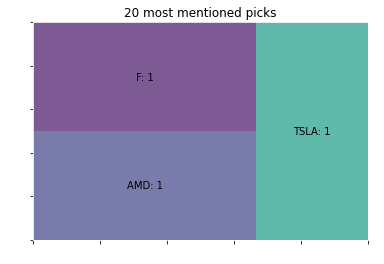

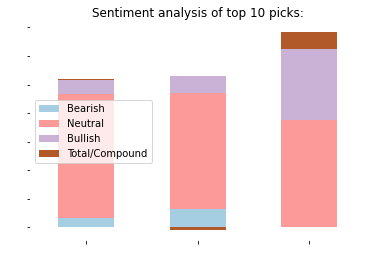

In [41]:
if __name__ == "__main__":
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    download(
        "omw-1.4", quiet=True,
    )
main()